In [1]:
import os
import cv2
import time
import random
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.cuda.amp as amp
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler 
from torch.utils.data import SequentialSampler
import torch.nn.functional as F
import albumentations as A
import gc

# from torchmetrics.functional import dice_score
from torch.optim.lr_scheduler import StepLR
import tifffile
is_amp = True
import logging
import pandas as pd
from sklearn.model_selection import KFold

import numpy as np
from itertools import repeat
import collections.abc

import warnings
warnings.filterwarnings('ignore')

/home/lakshita/somusan/hubmap_kaggle/.venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# root_dir = '/kaggle/working/'
# pretrain_dir = '/kaggle/input/swin-tiny-small-22k-pretrained/'

# TRAIN = '../input/hubmap-2022-256x256/train/'
# MASKS = '../input/hubmap-2022-256x256/masks/'
# LABELS = '../input/hubmap-organ-segmentation/train.csv'

df = pd.read_csv("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train.csv")

# !mkdir /kaggle/working/result
# !mkdir /kaggle/working/checkpoint

root_dir = '.'
pretrain_dir = '/home/lakshita/somusan/hubmap_kaggle/nbs/swin-tiny-small-22k-pretrained'

TRAIN = '/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-22-aug-pixel-size'
MASKS = '/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks'
LABELS = '/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train.csv'

In [10]:
def image_to_tensor(image, mode='bgr'): #image mode
    if mode=='bgr':
        image = image[:,:,::-1]
    x = image
    x = x.transpose(2,0,1)
    x = np.ascontiguousarray(x)
    x = torch.tensor(x, dtype=torch.float)
    return x


def mask_to_tensor(mask):
    x = mask
    x = torch.tensor(x, dtype=torch.float)
    return x


tensor_list = ['mask', 'image', 'organ']

def null_collate(batch):
    d = {}
    key = batch[0].keys()
    for k in key:
        v = [b[k] for b in batch]
        if k in tensor_list:
            v = torch.stack(v)
        d[k] = v

    d['mask'] = d['mask'].unsqueeze(1)
    d['organ'] = d['organ'].reshape(-1)
    return d


def _ntuple(n):
    def parse(x):
        if isinstance(x, collections.abc.Iterable):
            return x
        return tuple(repeat(x, n))
    return parse


to_2tuple = _ntuple(2)


def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

        
def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)


def drop_path(x, drop_prob: float = 0., training: bool = False, scale_by_keep: bool = True):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = x.new_empty(shape).bernoulli_(keep_prob)
    if keep_prob > 0.0 and scale_by_keep:
        random_tensor.div_(keep_prob)
    return x * random_tensor


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob: float = 0., scale_by_keep: bool = True):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
        self.scale_by_keep = scale_by_keep

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training, self.scale_by_keep)

    def extra_repr(self):
        return f'drop_prob={round(self.drop_prob,3):0.3f}'
    
    
class RGB(nn.Module):
    IMAGE_RGB_MEAN = [0.485, 0.456, 0.406] #[0.5, 0.5, 0.5]
    IMAGE_RGB_STD  = [0.229, 0.224, 0.225] #[0.5, 0.5, 0.5]

    def __init__(self,):
        super(RGB, self).__init__()
        self.register_buffer('mean', torch.zeros(1,3,1,1))
        self.register_buffer('std', torch.ones(1,3,1,1))
        self.mean.data = torch.FloatTensor(self.IMAGE_RGB_MEAN).view(self.mean.shape)
        self.std.data = torch.FloatTensor(self.IMAGE_RGB_STD).view(self.std.shape)

    def forward(self, x):
        x = (x-self.mean)/self.std
        return x
    
    
def message(mode='print'):
    asterisk = ' '
    if mode==('print'):
        loss = batch_loss
    if mode==('log'):
        loss = train_loss
        if (iteration % iter_save == 0): asterisk = '*'

    text = \
        ('%0.2e   %08d%s %6.2f | '%(rate, iteration, asterisk, epoch,)).replace('e-0','e-').replace('e+0','e+') + \
        '%4.3f  %4.3f  %4.4f  %4.3f   | '%(*valid_loss,) + \
        '%4.3f  %4.3f   | '%(*loss,) + \
        '%s' % ((time.time() - start_timer))

    return text

In [11]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def image_to_tensor(image, mode='bgr'): #image mode
    if mode=='bgr':
        image = image[:,:,::-1]
    x = image
    x = x.transpose(2,0,1)
    x = np.ascontiguousarray(x)
    x = torch.tensor(x, dtype=torch.float)
    return x


def mask_to_tensor(mask):
    x = mask
    x = torch.tensor(x, dtype=torch.float)
    return x

    
    
class RGB(nn.Module):
    IMAGE_RGB_MEAN = [0.485, 0.456, 0.406] #[0.5, 0.5, 0.5]
    IMAGE_RGB_STD  = [0.229, 0.224, 0.225] #[0.5, 0.5, 0.5]

    def __init__(self,):
        super(RGB, self).__init__()
        self.register_buffer('mean', torch.zeros(1,3,1,1))
        self.register_buffer('std', torch.ones(1,3,1,1))
        self.mean.data = torch.FloatTensor(self.IMAGE_RGB_MEAN).view(self.mean.shape)
        self.std.data = torch.FloatTensor(self.IMAGE_RGB_STD).view(self.std.shape)

    def forward(self, x):
        x = (x-self.mean)/self.std
        return x
    
    
def message(mode='print'):
    asterisk = ' '
    if mode==('print'):
        loss = batch_loss
    if mode==('log'):
        loss = train_loss
        if (iteration % iter_save == 0): asterisk = '*'

    text = \
        ('%0.2e   %08d%s %6.2f | '%(rate, iteration, asterisk, epoch,)).replace('e-0','e-').replace('e+0','e+') + \
        '%4.3f  %4.3f  %4.4f  %4.3f   | '%(*valid_loss,) + \
        '%4.3f  %4.3f   | '%(*loss,) + \
        '%s' % ((time.time() - start_timer))

    return text

In [12]:
def valid_augment5(image, mask, organ):
    #image, mask  = do_crop(image, mask, image_size, xy=(None,None))
    return image, mask

def train_augment5b(image, mask, organ):
    image, mask = do_random_flip(image, mask)
    image, mask = do_random_rot90(image, mask)

    for fn in np.random.choice([
        lambda image, mask: (image, mask),
        lambda image, mask: do_random_noise(image, mask, mag=0.1),
        lambda image, mask: do_random_contast(image, mask, mag=0.40),
        lambda image, mask: do_random_hsv(image, mask, mag=[0.40, 0.40, 0])
    ], 2): image, mask = fn(image, mask)

    for fn in np.random.choice([
        lambda image, mask: (image, mask),
        lambda image, mask: do_random_rotate_scale(image, mask, angle=45, scale=[0.50, 2.0]),
    ], 1): image, mask = fn(image, mask)

    return image, mask

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="augmentations"><center>Augmentations</center></h3>

In [13]:
def do_random_flip(image, mask):
    if np.random.rand()>0.5:
        image = cv2.flip(image,0)
        mask = cv2.flip(mask,0)
    if np.random.rand()>0.5:
        image = cv2.flip(image,1)
        mask = cv2.flip(mask,1)
    if np.random.rand()>0.5:
        image = image.transpose(1,0,2)
        mask = mask.transpose(1,0)
    
    image = np.ascontiguousarray(image)
    mask = np.ascontiguousarray(mask)
    return image, mask

def do_random_rot90(image, mask):
    r = np.random.choice([
        0,
        cv2.ROTATE_90_CLOCKWISE,
        cv2.ROTATE_90_COUNTERCLOCKWISE,
        cv2.ROTATE_180,
    ])
    if r==0:
        return image, mask
    else:
        image = cv2.rotate(image, r)
        mask = cv2.rotate(mask, r)
        return image, mask
    
def do_random_contast(image, mask, mag=0.3):
    alpha = 1 + random.uniform(-1,1)*mag
    image = image * alpha
    image = np.clip(image,0,1)
    return image, mask

def do_random_hsv(image, mask, mag=[0.15,0.25,0.25]):
    image = (image*255).astype(np.uint8)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    h = hsv[:, :, 0].astype(np.float32)  # hue
    s = hsv[:, :, 1].astype(np.float32)  # saturation
    v = hsv[:, :, 2].astype(np.float32)  # value
    h = (h*(1 + random.uniform(-1,1)*mag[0]))%180
    s =  s*(1 + random.uniform(-1,1)*mag[1])
    v =  v*(1 + random.uniform(-1,1)*mag[2])

    hsv[:, :, 0] = np.clip(h,0,180).astype(np.uint8)
    hsv[:, :, 1] = np.clip(s,0,255).astype(np.uint8)
    hsv[:, :, 2] = np.clip(v,0,255).astype(np.uint8)
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    image = image.astype(np.float32)/255
    return image, mask

def do_random_noise(image, mask, mag=0.1):
    height, width = image.shape[:2]
    noise = np.random.uniform(-1,1, (height, width,1))*mag
    image = image + noise
    image = np.clip(image,0,1)
    return image, mask

def do_random_rotate_scale(image, mask, angle=30, scale=[0.8,1.2] ):
    angle = np.random.uniform(-angle, angle)
    scale = np.random.uniform(*scale) if scale is not None else 1
    
    height, width = image.shape[:2]
    center = (height // 2, width // 2)
    
    transform = cv2.getRotationMatrix2D(center, angle, scale)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
    mask  = cv2.warpAffine( mask, transform, (width, height), flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image, mask

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="dataset"><center>Dataset</center></h3>

In [14]:
image_size = 512

class HubmapDataset(Dataset):
    def __init__(self, df, augment=None):

        self.df = df
        self.augment = augment
        self.length = len(self.df)
        self.organ_to_label = {'kidney' : 0,
                               'prostate' : 1,
                               'largeintestine' : 2,
                               'spleen' : 3,
                               'lung' : 4}

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k, d.get(k,0), d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]
        img_height = self.df.loc[index, 'img_height']
        img_width = self.df.loc[index, 'img_width']
        organ = self.organ_to_label[d.organ]

        image = cv2.cvtColor(tifffile.imread(os.path.join(TRAIN, f'{d.id}.tiff')), cv2.COLOR_BGR2RGB)
        
        rle_mask = self.df.loc[index, 'rle']
        mask = rle_decode(rle_mask, (img_height, img_width))
        #mask = cv2.cvtColor(mask, cv2.IMREAD_GRAYSCALE)
        #mask = cv2.imread(os.path.join(MASKS,fname),cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis = 2)
        #print(mask.shape)
        
        image = image.astype(np.float32)/255
        #mask  = mask.astype(np.float32)/255
        mask = mask.astype(np.float32)

        s = d.pixel_size/0.4 * (image_size/3000)
        image = cv2.resize(image,dsize=(image_size,image_size),interpolation=cv2.INTER_LINEAR)
        mask  = cv2.resize(mask, dsize=(image_size,image_size),interpolation=cv2.INTER_LINEAR)

        if self.augment is not None:
            image, mask = self.augment(image, mask, organ)


        r ={}
        r['index']= index
        r['organ'] = torch.tensor([organ], dtype=torch.long)
        r['image'] = image_to_tensor(image)
        r['mask' ] = mask_to_tensor(mask)
        return r

In [15]:
# class FPN(nn.Module):
#     def __init__(self, input_channels:list, output_channels:list):
#         super().__init__()
#         self.convs = nn.ModuleList(
#             [nn.Sequential(nn.Conv2d(in_ch, out_ch*2, kernel_size=3, padding=1),
#              nn.ReLU(inplace=True), nn.BatchNorm2d(out_ch*2),
#              nn.Conv2d(out_ch*2, out_ch, kernel_size=3, padding=1))
#             for in_ch, out_ch in zip(input_channels, output_channels)])
        
#     def forward(self, xs:list, last_layer):
#         hcs = [F.interpolate(c(x),scale_factor=2**(len(self.convs)-i),mode='bilinear') 
#                for i,(c,x) in enumerate(zip(self.convs, xs))]
#         hcs.append(last_layer)
#         return torch.cat(hcs, dim=1)

# class UnetBlock(nn.Module):
#     def __init__(self, up_in_c:int, x_in_c:int, nf:int=None, blur:bool=False,
#                  self_attention:bool=False, **kwargs):
#         super().__init__()
#         self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, **kwargs)
#         self.bn = nn.BatchNorm2d(x_in_c)
#         ni = up_in_c//2 + x_in_c
#         nf = nf if nf is not None else max(up_in_c//2,32)
#         self.conv1 = ConvLayer(ni, nf, norm_type=None, **kwargs)
#         self.conv2 = ConvLayer(nf, nf, norm_type=None,
#             xtra=SelfAttention(nf) if self_attention else None, **kwargs)
#         self.relu = nn.ReLU(inplace=True)

#     def forward(self, up_in:Tensor, left_in:Tensor) -> Tensor:
#         s = left_in
#         up_out = self.shuf(up_in)
#         cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1))
#         return self.conv2(self.conv1(cat_x))
        
# class _ASPPModule(nn.Module):
#     def __init__(self, inplanes, planes, kernel_size, padding, dilation, groups=1):
#         super().__init__()
#         self.atrous_conv = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
#                 stride=1, padding=padding, dilation=dilation, bias=False, groups=groups)
#         self.bn = nn.BatchNorm2d(planes)
#         self.relu = nn.ReLU()

#         self._init_weight()

#     def forward(self, x):
#         x = self.atrous_conv(x)
#         x = self.bn(x)

#         return self.relu(x)

#     def _init_weight(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 torch.nn.init.kaiming_normal_(m.weight)
#             elif isinstance(m, nn.BatchNorm2d):
#                 m.weight.data.fill_(1)
#                 m.bias.data.zero_()

# class ASPP(nn.Module):
#     def __init__(self, inplanes=512, mid_c=256, dilations=[6, 12, 18, 24], out_c=None):
#         super().__init__()
#         self.aspps = [_ASPPModule(inplanes, mid_c, 1, padding=0, dilation=1)] + \
#             [_ASPPModule(inplanes, mid_c, 3, padding=d, dilation=d,groups=4) for d in dilations]
#         self.aspps = nn.ModuleList(self.aspps)
#         self.global_pool = nn.Sequential(nn.AdaptiveMaxPool2d((1, 1)),
#                         nn.Conv2d(inplanes, mid_c, 1, stride=1, bias=False),
#                         nn.BatchNorm2d(mid_c), nn.ReLU())
#         out_c = out_c if out_c is not None else mid_c
#         self.out_conv = nn.Sequential(nn.Conv2d(mid_c*(2+len(dilations)), out_c, 1, bias=False),
#                                     nn.BatchNorm2d(out_c), nn.ReLU(inplace=True))
#         self.conv1 = nn.Conv2d(mid_c*(2+len(dilations)), out_c, 1, bias=False)
#         self._init_weight()

#     def forward(self, x):
#         x0 = self.global_pool(x)
#         xs = [aspp(x) for aspp in self.aspps]
#         x0 = F.interpolate(x0, size=xs[0].size()[2:], mode='bilinear', align_corners=True)
#         x = torch.cat([x0] + xs, dim=1)
#         return self.out_conv(x)
    
#     def _init_weight(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 torch.nn.init.kaiming_normal_(m.weight)
#             elif isinstance(m, nn.BatchNorm2d):
#                 m.weight.data.fill_(1)
#                 m.bias.data.zero_()


# class config:
#     pretrained_root = '../input/efficientnet-pytorch/'
#     efficient_net_encoders = {
#         "efficientnet-b0": {
#             "out_channels": (3, 32, 24, 40, 112, 320),
#             "stage_idxs": (3, 5, 9, 16),
#             "weight_path": pretrained_root + "efficientnet-b0-08094119.pth"
#         },
#         "efficientnet-b1": {
#             "out_channels": (3, 32, 24, 40, 112, 320),
#             "stage_idxs": (5, 8, 16, 23),
#             "weight_path": pretrained_root + "efficientnet-b1-dbc7070a.pth"
#         },
#         "efficientnet-b2": {
#             "out_channels": (3, 32, 24, 48, 120, 352),
#             "stage_idxs": (5, 8, 16, 23),
#             "weight_path": pretrained_root + "efficientnet-b2-27687264.pth"
#         },
#         "efficientnet-b3": {
#             "out_channels": (3, 40, 32, 48, 136, 384),
#             "stage_idxs": (5, 8, 18, 26),
#             "weight_path": pretrained_root + "efficientnet-b3-c8376fa2.pth"
#         },
#         "efficientnet-b4": {
#             "out_channels": (3, 48, 32, 56, 160, 448),
#             "stage_idxs": (6, 10, 22, 32),
#             "weight_path": pretrained_root + "efficientnet-b4-e116e8b3.pth"
#         },
#         "efficientnet-b5": {
#             "out_channels": (3, 48, 40, 64, 176, 512),
#             "stage_idxs": (8, 13, 27, 39),
#             "weight_path": pretrained_root + "efficientnet-b5-586e6cc6.pth"
#         },
#         "efficientnet-b6": {
#             "out_channels": (3, 56, 40, 72, 200, 576),
#             "stage_idxs": (9, 15, 31, 45),
#             "weight_path": pretrained_root + "efficientnet-b6-c76e70fd.pth"
#         },
#         "efficientnet-b7": {
#             "out_channels": (3, 64, 48, 80, 224, 640),
#             "stage_idxs": (11, 18, 38, 55),
#             "weight_path": pretrained_root + "efficientnet-b7-dcc49843.pth"
#         }
#     }
#     model = 'efficientnet-b7'
    
# class EfficientNetEncoder(EfficientNet):
#     def __init__(self, stage_idxs, out_channels, model_name, depth=5):

#         blocks_args, global_params = get_model_params(model_name, override_params=None)
#         super().__init__(blocks_args, global_params)
        
#         cfg = config.efficient_net_encoders[model_name]

#         self._stage_idxs = stage_idxs
#         self._out_channels = out_channels
#         self._depth = depth
#         self._in_channels = 3

#         del self._fc
#         self.load_state_dict(torch.load(cfg['weight_path']))

#     def get_stages(self):
#         return [
#             nn.Identity(),
#             nn.Sequential(self._conv_stem, self._bn0, self._swish),
#             self._blocks[:self._stage_idxs[0]],
#             self._blocks[self._stage_idxs[0]:self._stage_idxs[1]],
#             self._blocks[self._stage_idxs[1]:self._stage_idxs[2]],
#             self._blocks[self._stage_idxs[2]:],
#         ]

#     def forward(self, x):
#         stages = self.get_stages()

#         block_number = 0.
#         drop_connect_rate = self._global_params.drop_connect_rate

#         features = []
#         for i in range(self._depth + 1):

#             # Identity and Sequential stages
#             if i < 2:
#                 x = stages[i](x)

#             # Block stages need drop_connect rate
#             else:
#                 for module in stages[i]:
#                     drop_connect = drop_connect_rate * block_number / len(self._blocks)
#                     block_number += 1.
#                     x = module(x, drop_connect)

#             features.append(x)

#         return features

#     def load_state_dict(self, state_dict, **kwargs):
#         state_dict.pop("_fc.bias")
#         state_dict.pop("_fc.weight")
#         super().load_state_dict(state_dict, **kwargs)  
        

# class EffUnet(nn.Module):
#     def __init__(self, model_name, stride=1):
#         super().__init__()
        
#         cfg = config.efficient_net_encoders[model_name]
#         stage_idxs = cfg['stage_idxs']
#         out_channels = cfg['out_channels']
        
#         self.encoder = EfficientNetEncoder(stage_idxs, out_channels, model_name)

#         #aspp with customized dilatations
#         self.aspp = ASPP(out_channels[-1], 256, out_c=384, 
#                          dilations=[stride*1, stride*2, stride*3, stride*4])
#         self.drop_aspp = nn.Dropout2d(0.5)
#         #decoder
#         self.dec4 = UnetBlock(384, out_channels[-2], 256)
#         self.dec3 = UnetBlock(256, out_channels[-3], 128)
#         self.dec2 = UnetBlock(128, out_channels[-4], 64)
#         self.dec1 = UnetBlock(64, out_channels[-5], 32)
#         self.fpn = FPN([384, 256, 128, 64], [16]*4)
#         self.drop = nn.Dropout2d(0.1)
#         self.final_conv = ConvLayer(32+16*4, 1, ks=1, norm_type=None, act_cls=None)
        
#         self.rgb = RGB()
        
#     def forward(self, batch):
#         x = batch['image']
#         B, C, H, W = x.shape
#         x = self.rgb(x)
#         enc0, enc1, enc2, enc3, enc4 = self.encoder(x)[-5:]
#         enc5 = self.aspp(enc4)
#         dec3 = self.dec4(self.drop_aspp(enc5), enc3)
#         dec2 = self.dec3(dec3,enc2)
#         dec1 = self.dec2(dec2,enc1)
#         dec0 = self.dec1(dec1,enc0)
#         x = self.fpn([enc5, dec3, dec2, dec1], dec0)
#         x = self.final_conv(self.drop(x))
#         x = F.interpolate(x, size = 512, mode = 'bilinear')
#         return x

In [16]:
class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """
    def __init__(self,
                 patch_size=4,
                 in_chans=3,
                 embed_dim=96,
                 norm_layer=None
                 ):
        super().__init__()
        patch_size = to_2tuple(patch_size)
        self.patch_size = patch_size

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape

        # padding
        if W % self.patch_size[1] != 0:
            x = F.pad(x, (0, self.patch_size[1] - W % self.patch_size[1]))
        if H % self.patch_size[0] != 0:
            x = F.pad(x, (0, 0, 0, self.patch_size[0] - H % self.patch_size[0]))


        x = self.proj(x)  # B C Wh Ww
        if self.norm is not None:
            Wh, Ww = x.size(2), x.size(3)
            x = x.flatten(2).transpose(1, 2)
            x = self.norm(x)
            x = x.transpose(1, 2).view(-1, self.embed_dim, Wh, Ww)

        return x
    
    
class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x, H, W):
        """
        Args:
            x: Input feature, tensor size (B, H*W, C).
            H, W: Spatial resolution of the input feature.
        """

        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"


        x = x.view(B, H, W, C)
        # padding
        pad_input = (H % 2 == 1) or (W % 2 == 1)
        if pad_input:
            x = F.pad(x, (0, 0, 0, W % 2, 0, H % 2))

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B, H/2, W/2, 4*C
        x = x.view(B, -1, 4 * C)  # B, H/2*W/2, 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x
    
    
class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        fused_window_process (bool, optional): If True, use one kernel to fused window shift & window partition for acceleration, similar for the reversed part. Default: False
    """
    def __init__(self,
        dim,
        depth,
        num_heads,
        window_size,
        mlp_ratio=4.,
        qkv_bias=True,
        qk_scale=None,
        drop=0.,
        attn_drop=0.,
        drop_path=0.,
        norm_layer=nn.LayerNorm,
        downsample=None,
        #use_checkpoint=False,
    ):
        super().__init__()
        self.window_size = window_size
        self.shift_size = window_size // 2
        self.depth = depth

        self.blocks = nn.ModuleList([
            SwinTransformerBlock(
                dim=dim,
                num_heads=num_heads,
                window_size=window_size,
                shift_size=0 if (i % 2 == 0) else window_size // 2,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop,
                attn_drop=attn_drop,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer,
            )
            for i in range(depth)
        ])
        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x, H, W):
        """
        Args:
            x: Input feature, tensor size (B, H*W, C).
            H, W: Spatial resolution of the input feature.
        """

        # calculate attention mask for SW-MSA ----
        Hp = int(np.ceil(H / self.window_size)) * self.window_size
        Wp = int(np.ceil(W / self.window_size)) * self.window_size
        img_mask = torch.zeros((1, Hp, Wp, 1), device=x.device)  # 1 Hp Wp 1
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        #------


        for blk in self.blocks:
            x = blk(x, H, W, attn_mask)

        if self.downsample is not None:
            x_down = self.downsample(x, H, W)
            Wh, Ww = (H + 1) // 2, (W + 1) // 2
            return x, H, W, x_down, Wh, Ww
        else:
            return x, H, W, x, H, W
        
        
class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
        fused_window_process (bool, optional): If True, use one kernel to fused window shift & window partition for acceleration, similar for the reversed part. Default: False
    """
    def __init__(self,
        dim,
        num_heads,
        window_size=7,
        shift_size=0,
        mlp_ratio=4.,
        qkv_bias=True,
        qk_scale=None,
        drop=0.,
        attn_drop=0.,
        drop_path=0.,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
    ):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim,
            window_size=to_2tuple(self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            attn_drop=attn_drop,
            proj_drop=drop,
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)


    def forward(self, x, H, W, mask_matrix):

        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # pad feature maps to multiples of window size
        pad_l = pad_t = 0
        pad_r = (self.window_size - W % self.window_size) % self.window_size
        pad_b = (self.window_size - H % self.window_size) % self.window_size
        x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b))
        _, Hp, Wp, _ = x.shape


        # cyclic shift ---
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
            attn_mask = mask_matrix
        else:
            shifted_x = x
            attn_mask = None

        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C
        attn_windows = self.attn(x_windows, mask=attn_mask)  # nW*B, window_size*window_size, C
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)


        # reverse cyclic shift ---
        shifted_x = window_reverse(attn_windows, self.window_size, Hp, Wp)  # B H' W' C
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x

        if pad_r > 0 or pad_b > 0:
            x = x[:, :H, :W, :].contiguous()
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    
class SwinTransformerV1(nn.Module):
    def __init__(self,
        pretrain_img_size=224,
        patch_size=4,
        in_chans=3,
        embed_dim=96,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        window_size=7,
        mlp_ratio=4.,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.,
        attn_drop_rate=0.,
        drop_path_rate=0.1,
        norm_layer=nn.LayerNorm,
        patch_norm=True,
        out_norm = nn.Identity, #use nn.Identity, nn.BatchNorm2d, LayerNorm2d
        **kwargs
    ):
        super().__init__()
        self.pretrain_img_size = pretrain_img_size
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.mlp_ratio = mlp_ratio


        self.patch_embed = PatchEmbed(
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
            norm_layer=norm_layer if patch_norm else None
        )
        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = np.linspace(0, drop_path_rate, sum(depths)).tolist() # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i in range(self.num_layers):
            layer = BasicLayer(
                dim=int(embed_dim * 2 ** i),
                depth=depths[i],
                num_heads=num_heads[i],
                window_size=window_size,
                mlp_ratio=self.mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[sum(depths[:i]):sum(depths[:i + 1])],
                norm_layer=norm_layer,
                downsample=PatchMerging if (i < self.num_layers - 1) else None,
            )
            self.layers.append(layer)

        #---
        # add a norm layer for each output
        self.out_norm = nn.ModuleList(
            [ out_norm(int(embed_dim * 2 ** i)) for i in range(self.num_layers)]
        )

        #---
        self.apply(self._init_weights)


    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)


    def forward(self, x):
        x = self.patch_embed(x)
        Wh, Ww = x.size(2), x.size(3)

        #positional encode?
        x = x.flatten(2).transpose(1, 2)
        x = self.pos_drop(x)

        outs = []
        for i in range(self.num_layers):
            x_out, H, W, x, Wh, Ww = self.layers[i](x, Wh, Ww)
            out = x_out.view(-1, H, W, int(self.embed_dim * 2 ** i)).permute(0, 3, 1, 2).contiguous()
            out = self.out_norm[i](out)
            outs.append(out)

        return outs
class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** (-0.5)

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)
        self.softmax = nn.Softmax(dim=-1)

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)


    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """

        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = \
            self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], self.num_heads)
            # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww

        attn = attn + relative_position_bias.unsqueeze(0)


        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'
    
    
def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


def conv3x3_bn_relu(in_planes, out_planes, stride=1):
    "3x3 convolution + BN + relu"
    return nn.Sequential(
        nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(out_planes),
        nn.ReLU(inplace=True),
    )


class UPerDecoder(nn.Module):
    def __init__(self,
        in_dim=[256, 512, 1024, 2048],
        ppm_pool_scale=[1, 2, 3, 6],
        ppm_dim=512,
        fpn_out_dim=256
    ):
        super(UPerDecoder, self).__init__()

        # PPM ----
        dim = in_dim[-1]
        ppm_pooling = []
        ppm_conv = []

        for scale in ppm_pool_scale:
            ppm_pooling.append(
                nn.AdaptiveAvgPool2d(scale)
            )
            ppm_conv.append(
                nn.Sequential(
                    nn.Conv2d(dim, ppm_dim, kernel_size=1, bias=False),
                    nn.BatchNorm2d(ppm_dim),
                    nn.ReLU(inplace=True)
                )
            )
        self.ppm_pooling   = nn.ModuleList(ppm_pooling)
        self.ppm_conv      = nn.ModuleList(ppm_conv)
        self.ppm_out = conv3x3_bn_relu(dim + len(ppm_pool_scale)*ppm_dim, fpn_out_dim, 1)

        # FPN ----
        fpn_in = []
        for i in range(0, len(in_dim)-1):  # skip the top layer
            fpn_in.append(
                nn.Sequential(
                    nn.Conv2d(in_dim[i], fpn_out_dim, kernel_size=1, bias=False),
                    nn.BatchNorm2d(fpn_out_dim),
                    nn.ReLU(inplace=True)
                )
            )
        self.fpn_in = nn.ModuleList(fpn_in)

        fpn_out = []
        for i in range(len(in_dim) - 1):  # skip the top layer
            fpn_out.append(
                conv3x3_bn_relu(fpn_out_dim, fpn_out_dim, 1),
            )
        self.fpn_out = nn.ModuleList(fpn_out)

        self.fpn_fuse = nn.Sequential(
            conv3x3_bn_relu(len(in_dim) * fpn_out_dim, fpn_out_dim, 1),
        )

    def forward(self, feature):
        f = feature[-1]
        pool_shape = f.shape[2:]

        ppm_out = [f]
        for pool, conv in zip(self.ppm_pooling, self.ppm_conv):
            p = pool(f)
            p = F.interpolate(p, size=pool_shape, mode='bilinear', align_corners=False)
            p = conv(p)
            ppm_out.append(p)
        ppm_out = torch.cat(ppm_out, 1)
        down = self.ppm_out(ppm_out)

        fpn_out = [down]
        for i in reversed(range(len(feature) - 1)):
            lateral = feature[i]
            lateral = self.fpn_in[i](lateral) # lateral branch
            down = F.interpolate(down, size=lateral.shape[2:], mode='bilinear', align_corners=False) # top-down branch
            down = down + lateral
            fpn_out.append(self.fpn_out[i](down))

        fpn_out.reverse() # [P2 - P5]
        fusion_shape = fpn_out[0].shape[2:]
        fusion = [fpn_out[0]]
        for i in range(1, len(fpn_out)):
            fusion.append(
                F.interpolate( fpn_out[i], fusion_shape, mode='bilinear', align_corners=False)
            )
        x = self.fpn_fuse( torch.cat(fusion, 1))

        return x, fusion
    
    
    
class LayerNorm2d(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.bias = nn.Parameter(torch.zeros(dim))
        self.eps = eps

    def forward(self, x):
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight[:, None, None] * x + self.bias[:, None, None]
        return x
    
    
    
def criterion_aux_loss(logit, mask):
    mask = F.interpolate(mask,size=logit.shape[-2:], mode='nearest')
    loss = F.binary_cross_entropy_with_logits(logit,mask)
    return loss



class Net(nn.Module):

    def load_pretrain( self,):

        checkpoint = cfg[self.arch]['checkpoint']
        print('loading %s ...'%checkpoint)
        checkpoint = torch.load(checkpoint, map_location=lambda storage, loc: storage)['model']
        if 0:
            skip = ['relative_coords_table','relative_position_index']
            filtered={}
            for k,v in checkpoint.items():
                if any([s in k for s in skip ]): continue
                filtered[k]=v
            checkpoint = filtered
        print(self.encoder.load_state_dict(checkpoint,strict=False))  #True


    def __init__( self,):
        super(Net, self).__init__()
        self.output_type = ['inference']

        self.rgb = RGB()
        self.arch = 'swin_tiny_patch4_window7_224'

        self.encoder = SwinTransformerV1(
            ** {**cfg['basic']['swin'], **cfg[self.arch]['swin'],
                **{'out_norm' : LayerNorm2d} }
        )
        encoder_dim =cfg[self.arch]['upernet']['in_channels']
        #[96, 192, 384, 768]

        self.decoder = UPerDecoder(
            in_dim=encoder_dim,
            ppm_pool_scale=[1, 2, 3, 6],
            ppm_dim=512,
            fpn_out_dim=256
        )

        self.logit = nn.Sequential(
            nn.Conv2d(256, 1, kernel_size=1)
        )
        self.aux = nn.ModuleList([
            nn.Conv2d(256, 1, kernel_size=1, padding=0) for i in range(4)
        ])



    def forward(self, batch):
        x = batch['image']
        B,C,H,W = x.shape
        x = self.rgb(x)
        encoder = self.encoder(x)
        last, decoder = self.decoder(encoder)
        logit = self.logit(last)
        logit = F.interpolate(logit, size=None, scale_factor=4, mode='bilinear', align_corners=False)

        output = {}
        if 'loss' in self.output_type:
            output['bce_loss'] = F.binary_cross_entropy_with_logits(logit,batch['mask'])
            for i in range(4):
                output['aux%d_loss'%i] = criterion_aux_loss(self.aux[i](decoder[i]),batch['mask'])

        if 'inference' in self.output_type:
            output['probability'] = torch.sigmoid(logit)

        return output

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="folds"><center>Folds</center></h3>

In [17]:
class Mlp(nn.Module):
    """ Multilayer perceptron."""

    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x
    
    
cfg = dict(

        #configs/_base_/models/upernet_swin.py
        basic = dict(
            swin=dict(
                embed_dim=96,
                depths=[2, 2, 6, 2],
                num_heads=[3, 6, 12, 24],
                window_size=7,
                mlp_ratio=4.,
                qkv_bias=True,
                qk_scale=None,
                drop_rate=0.,
                attn_drop_rate=0.,
                drop_path_rate=0.3,
                ape=False,
                patch_norm=True,
                out_indices=(0, 1, 2, 3),
                use_checkpoint=False
            ),

        ),

        #configs/swin/upernet_swin_tiny_patch4_window7_512x512_160k_ade20k.py
        swin_tiny_patch4_window7_224=dict(
            checkpoint = pretrain_dir+'/swin_tiny_patch4_window7_224_22k.pth',

            swin = dict(
                embed_dim=96,
                depths=[2, 2, 6, 2],
                num_heads=[3, 6, 12, 24],
                window_size=7,
                ape=False,
                drop_path_rate=0.3,
                patch_norm=True,
                use_checkpoint=False,
            ),
            upernet=dict(
                in_channels=[96, 192, 384, 768],
            ),
        ),

        #/configs/swin/upernet_swin_small_patch4_window7_512x512_160k_ade20k.py
        swin_small_patch4_window7_224_22k=dict(
            checkpoint = pretrain_dir+'/swin_small_patch4_window7_224_22k.pth',

            swin = dict(
                embed_dim=96,
                depths=[2, 2, 18, 2],
                num_heads=[3, 6, 12, 24],
                window_size=7,
                ape=False,
                drop_path_rate=0.3,
                patch_norm=True,
                use_checkpoint=False
            ),
            upernet=dict(
                in_channels=[96, 192, 384, 768],
            ),
        ),
    )

In [18]:
def make_fold(fold=3):
    df = pd.read_csv('../input/hubmap-organ-segmentation/train.csv')

    num_fold = 5
    skf = KFold(n_splits=num_fold, shuffle=True,random_state=42)

    df.loc[:,'fold']=-1
    for f,(t_idx, v_idx) in enumerate(skf.split(X=df['id'], y=df['organ'])):
        df.iloc[v_idx,-1]=f

    #check
    if 0:
        for f in range(num_fold):
            train_df=df[df.fold!=f].reset_index(drop=True)
            valid_df=df[df.fold==f].reset_index(drop=True)

            print('fold %d'%f)
            t = train_df.organ.value_counts().to_dict()
            v = valid_df.organ.value_counts().to_dict()
            for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
                print('%32s %3d (%0.3f)  %3d (%0.3f)'%(k,t.get(k,0),t.get(k,0)/len(train_df),v.get(k,0),v.get(k,0)/len(valid_df)))

            print('')
            zz=0

    train_df=df[df.fold!=fold].reset_index(drop=True)
    valid_df=df[df.fold==fold].reset_index(drop=True)
    return train_df,valid_df

In [19]:
def compute_dice_score(probability, mask, smooth = 1):
    N = len(probability)
    p = probability.reshape(N,-1)
    t = mask.reshape(N,-1)

    p = p>0.5
    t = t>0.5
    uion = p.sum(-1) + t.sum(-1)
    overlap = (p*t).sum(-1)
    dice = 2*overlap/(uion+0.0001)
    return dice

In [20]:
def get_learning_rate(optimizer):
    return optimizer.param_groups[0]['lr']

In [21]:
# organ_threshold = {
#     'kidney': 0.50,
#     'prostate': 0.50,
#     'largeintestine': 0.50,
#     'spleen': 0.50,
#     'lung': 0.20,
# }   

organ_threshold = {
    'Hubmap': {
        'kidney'        : 0.40,
        'prostate'      : 0.40,
        'largeintestine': 0.40,
        'spleen'        : 0.40,
        'lung'          : 0.10,
    },
    'HPA': {
        'kidney'        : 0.50,
        'prostate'      : 0.50,
        'largeintestine': 0.50,
        'spleen'        : 0.50,
        'lung'          : 0.10,
    },
}

In [22]:
# Stochastic Weight Averaging
# https://pytorch.org/blog/pytorch-1.6-now-includes-stochastic-weight-averaging/
def do_swa(checkpoint):
    skip = ['relative_position_index', 'num_batches_tracked']
    
    K = len(checkpoint)
    swa = None
    
    for k in range(K):
        state_dict = torch.load(checkpoint[k], map_location=lambda storage, loc: storage)['state_dict']
        if swa is None:
            swa = state_dict
        else:
            for k, v in state_dict.items():
                #print(k)
                if any(s in k for s in skip): continue
                swa[k] += v
    
    for k, v in swa.items():
        if any(s in k for s in skip): continue
        swa[k] /= K
    
    return swa

In [23]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

In [24]:
#root_dir = '../input/swin-10k'

In [25]:
from tqdm import tqdm

In [26]:
# #out_dir = root_dir + '/result/upernet-swin-v1-tiny-aux5-768'
# all_df = []
# valid = {
#     3: [
#         '../input/kaggle-hubmap-model-weights/00008514.model.pth',
#         '../input/kaggle-hubmap-model-weights/00008712.model.pth',
#         '../input/kaggle-hubmap-model-weights/00008910.model.pth',
#         ],
# }

# all_score_df = []
# for f, checkpoint in valid.items():
#     if len(checkpoint)==0: 
#         continue

#     #project_name = out_dir.split('/')[-1]
#     #fold_dir = out_dir + '/fold-%d' % f

#     #checkpoint = [fold_dir + '/checkpoint' + c for c in checkpoint]
#     checkpoint = [c for c in checkpoint]
#     swa = do_swa(checkpoint)
#     torch.save({
#         'state_dict': swa,
#         'swa': [c.split('/')[-1] for c in checkpoint],
#     }, 
#         f'./fold-{f}-swa.pth')
#     net = EffUnet(config.model).cuda()
# #     net = Net().cuda()
#     state_dict = swa
#     net.load_state_dict(state_dict, strict=False)  # True

#     net = net.eval()
#     net.output_type = ['inference']

#     result = {
#         'id': [],
#         'probability': [],
#         'rle': [],
#     }
    
# #     df = pd.read_csv("../input/hubmap-organ-segmentation/train.csv").iloc[0:10]
#     start_timer = time.time()
#     for t, d in tqdm(df.iterrows()):
        
#         fname = d['id']
#         image = tifffile.imread(f'../input/hubmap-organ-segmentation/test_images/{fname}.tiff')
#         image = image.astype(np.float32)/255
        
#         H, W, _ = image.shape

#         s = d.pixel_size / 0.4 * (image_size / 3000)
#         image = cv2.resize(image, dsize=(image_size,image_size), interpolation=cv2.INTER_LINEAR)

#         image = image_to_tensor(image)
#         image = image.cuda()
#         batch = {
#             'image':
#                 torch.stack([
#                     image,
#                     torch.flip(image, [1]),
#                     torch.flip(image, [2]),
#                 ]),  # simple TTA
#         }
        
#         probability = 0
#         with torch.no_grad():
#             with amp.autocast(enabled=is_amp):
#                 output = net(batch) 

#                 probability += F.interpolate(
#                     output, size=(H, W), mode='bilinear', align_corners=False, antialias=True)

#         # undo TTA
#         probability[1] = torch.flip(probability[1], [1])
#         probability[2] = torch.flip(probability[2], [2])
#         probability = probability.float().data.cpu().numpy().mean(0)[0]
#         #p = probability > organ_threshold[d.organ] 
#         p = probability > organ_threshold[d.data_source][d.organ] 
#         p = p.T
#         rle = rle_encode(p)
#         #rle = rle

#         result['rle'].append(rle)
#         result['probability'].append(p)
#         result['id'].append(fname)
#         print('\r', t, end='', flush=True)
#     print('')
#     submit_df = pd.DataFrame({'id': result['id'], 'rle': result['rle']})
#     print(submit_df)
#     all_df.append(submit_df)
#     print('submit_df ok!')
#     print('')

In [27]:
# submit_df.head()

In [28]:
# plt.imshow(rle_decode(submit_df["rle"].iloc[0], (2023,2023)))

In [29]:
# plt.imshow(result['probability'][0])

In [49]:
all_df = []
# valid = {
# #     0: [
# #         '../input/fold-0/result/upernet-swin-v1-tiny-aux5-768/fold-0/checkpoint/00004992.model.pth',
# #         '../input/fold-0/result/upernet-swin-v1-tiny-aux5-768/fold-0/checkpoint/00007776.model.pth',
# #         '../input/fold-0/result/upernet-swin-v1-tiny-aux5-768/fold-0/checkpoint/00009216.model.pth',
# #         ],
# #     1: [
# #         '../input/fold-1/result/upernet-swin-v1-tiny-aux5-768/fold-1/checkpoint/00007296.model.pth',
# #         '../input/fold-1/result/upernet-swin-v1-tiny-aux5-768/fold-1/checkpoint/00008736.model.pth',
# #         '../input/fold-1/result/upernet-swin-v1-tiny-aux5-768/fold-1/checkpoint/00009120.model.pth',
# #         ],
# #     2: [
# #         '../input/fold-2/result/upernet-swin-v1-tiny-aux5-768/fold-2/checkpoint/00005376.model.pth',
# #         '../input/fold-2/result/upernet-swin-v1-tiny-aux5-768/fold-2/checkpoint/00008832.model.pth',
# #         '../input/fold-2/result/upernet-swin-v1-tiny-aux5-768/fold-2/checkpoint/00009888.model.pth',
# #         ],
#     3: [
#         '../input/fold-3/result/upernet-swin-v1-tiny-aux5-768/fold-3/checkpoint/00008019.model.pth',
#         '../input/fold-3/result/upernet-swin-v1-tiny-aux5-768/fold-3/checkpoint/00008910.model.pth',
#         '../input/fold-3/result/upernet-swin-v1-tiny-aux5-768/fold-3/checkpoint/00009900.model.pth',
#         ],
# }


result = {
        'id': [],
        'probability': [],
        'rle': [],
    }
df = pd.read_csv("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train.csv")
start_timer = time.time()
for t, d in df.iterrows():

    fname = d['id']
    # image = tifffile.imread(f'../input/hubmap-organ-segmentation/test_images/{fname}.tiff')
    image = cv2.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-22-aug-pixel-size/127.png")

    image = image.astype(np.float32)/255

    H, W, _ = image.shape

    s = d.pixel_size / 0.4 * (image_size / 3000)
    image = cv2.resize(image, dsize=(image_size,image_size), interpolation=cv2.INTER_LINEAR)

    image = image_to_tensor(image)
    image = image.cuda()
    batch = {
        'image':
            torch.stack([
                image,
                torch.flip(image, [1]),
                torch.flip(image, [2]),
            ]),  # simple TTA
    }
    
    use = 0
    probability = 0
    with torch.no_grad():
        with amp.autocast(enabled = True):
            
            net = Net().cuda()
            state_dict = torch.load('/home/lakshita/somusan/hubmap_kaggle/nbs/result/upernet-swin-v1-tiny-aux5-768/fold-3/checkpoint_cutout/00005445.model.pth',
                        map_location=torch.device('cpu'))
            net.load_state_dict(state_dict['state_dict'])
#             state_dict = swa
#             net.load_state_dict(state_dict, strict=False)  # True

            net = net.eval()
#             net.output_type = ['inference']
            use += 1

            output = net(batch)
            #print(output['probability'].shape)
            probability += F.interpolate(
                output['probability'], size=(H, W), mode='bilinear', align_corners=False, antialias=True)

        #probability = probability / 4
        probability[0] = probability[0]   
        probability[1] = torch.flip(probability[1], [1])
        probability[2] = torch.flip(probability[2], [2])
        probability = probability.mean(0, keepdims=True)
        probability = probability[0,0].float()
        #probability = probability.float().data.cpu().numpy().mean(0)[0]
    
    probability = probability.data.cpu().numpy()
    #p = probability > organ_threshold[d.organ]
    p = probability > organ_threshold[d.data_source][d.organ]
    p = p.T

    rle = rle_encode(p)
    
    result['rle'].append(rle)
    result['probability'].append(p)
    result['id'].append(fname)
    print('\r', t, end='', flush=True)
    print('')
    break
    

submit_df = pd.DataFrame({'id': result['id'], 'rle': result['rle']})
print(submit_df)
print('submit_df ok!')
print('')

 0
      id                                                rle
0  10044  4588770 4 4591766 11 4594765 14 4597763 19 459...
submit_df ok!



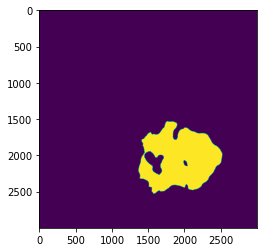

In [50]:
plt.imshow(result['probability'][0].reshape(3000,3000))

In [32]:


# plt.imshow(rle_decode(submit_df["rle"].iloc[0], (2023,2023)))

In [33]:
# type(submit_df["rle"].to_string())

In [34]:
# import matplotlib.pyplot as plt
# plt.imshow(p)
# print(p.shape)

In [35]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [36]:
submit_df.to_csv('submission.csv',index=False)